In [72]:
import numpy as np
from scipy.stats import norm, multivariate_normal

import matplotlib.pyplot as plt

from utils import traceplot, acfplot, pairplot

from ipynb.fs.full.rosenbrock import logpi_rosenbrock, partial_logpi_rosenbrock, hessian_logpi_rosenbrock

In [73]:
def project_to_psd(A):
    '''
    Project a matrix to the positive semidefinite cone.
    '''
    eigenvalues, eigenvectors = np.linalg.eigh(A)

    # Set negative eigenvalues to 1e-10 for numerical stability
    eigenvalues = np.maximum(eigenvalues, 1e-10)

    # Reconstruct the matrix
    A_psd = eigenvectors @ np.diag(eigenvalues) @ eigenvectors.T

    return A_psd

# MCMC Algorithms


## Random Walk Metropolis


In [74]:
def RWM_proposal(x, step_size):
    return x + step_size * np.random.normal(size=x.shape[0])


def RWM(logpi, n_iter, x_init, step_size=1, **kwargs):
    x = np.asarray(x_init)

    # (#components, #iterations)
    X = np.empty((x.shape[0], n_iter))

    # Counter for accepted proposals
    accepted = 0

    logpi_x = logpi(x, **kwargs)

    for i in range(n_iter):
        # Proposal state
        y = RWM_proposal(x, step_size)

        logpi_y = logpi(y, **kwargs)

        # Log RWM acceptance rate
        log_acceptance = logpi_y - logpi_x

        # Acceptance criterion
        if np.log(np.random.uniform(size=1)) < log_acceptance:
            x = y
            logpi_x = logpi_y
            accepted += 1

        X[:, i] = x

    acceptance_rate = accepted / n_iter

    return X, acceptance_rate

## Metropolis-Adjusted Langevin Algorithm


In [75]:
def MALA_proposal(x, partial_logpi_x, step_size):
    z = step_size * np.random.normal(size=x.shape[0])

    return x + (1/2) * (step_size**2) * partial_logpi_x + z


def MALA_logq_ratio(x, y, partial_logpi_x, partial_logpi_y, step_size):
    log_xy = multivariate_normal.logpdf(y, mean=(x + (1/2) * (step_size**2) * partial_logpi_x), cov=(step_size**2))
    log_yx = multivariate_normal.logpdf(x, mean=(y + (1/2) * (step_size**2) * partial_logpi_y), cov=(step_size**2))
    
    return log_yx - log_xy


def MALA(logpi, partial_logpi, n_iter, x_init, step_size=1, **kwargs):
    x = np.asarray(x_init)

    # (#components, #iterations)
    X = np.empty((x.shape[0], n_iter))

    # Counter for accepted proposals
    accepted = 0

    logpi_x = logpi(x, **kwargs)

    for i in range(n_iter):
        partial_logpi_x = partial_logpi(x, **kwargs)
        
        # Proposal state
        y = MALA_proposal(x, partial_logpi_x, step_size)
        
        logpi_y = logpi(y, **kwargs)
        partial_logpi_y = partial_logpi(y, **kwargs)

        # Log preconditioned MALA acceptance rate
        log_acceptance = logpi_y - logpi_x + MALA_logq_ratio(x, y, partial_logpi_x, partial_logpi_y, step_size)

        # Acceptance criterion
        if np.log(np.random.uniform(size=1)) < log_acceptance:
            x = y
            logpi_x = logpi_y
            accepted += 1

        X[:, i] = x
        
    acceptance_rate = accepted / n_iter

    return X, acceptance_rate

## Barker Metropolis-Hastings


In [76]:

def stable_log1p_exp(x):
    '''
    Compute log(1 + exp(x)) using the log-sum-exp trick for numerical stability.
    '''
    # return np.where(x > 0, x + np.log1p(np.exp(-x)), np.log1p(np.exp(x)))

    # For large positive x, exp(-x) -> 0, so directly return x
    return np.where(x > 700, x, np.where(x > 0, x + np.log1p(np.exp(-x)), np.log1p(np.exp(x))))


def Barker_proposal(x, partial_logpi_x, step_size):
    # Magnitude
    z = step_size * np.random.normal(size=len(x), scale=1)

    # Direction
    threshold = 1 / (1 + np.exp(- z * partial_logpi_x))
    b = np.where(np.random.uniform(size=1) < threshold, 1, -1) 

    return x + b * z


def Barker_logq_ratio(x, y, partial_logpi_x, partial_logpi_y):
    z = y - x

    logq_xy = - np.log1p(np.exp(- z * partial_logpi_x))
    logq_yx = - np.log1p(np.exp(z * partial_logpi_y))

    # logq_xy = -stable_log1p_exp(-z * partial_logpi_x)
    # logq_yx = -stable_log1p_exp(z * partial_logpi_y)

    return np.sum(logq_yx - logq_xy)
   

def Barker(logpi, partial_logpi, n_iter, x_init, step_size=1, **kwargs):
    x = np.asarray(x_init)

    # (#components, #iterations)
    X = np.empty((x.shape[0], n_iter))

    # Counter for accepted proposals
    accepted = 0

    logpi_x = logpi(x, **kwargs)
    
    for i in range(n_iter):
        partial_logpi_x = partial_logpi(x, **kwargs)

        # Proposal state
        y = Barker_proposal(x, partial_logpi_x, step_size)

        logpi_y = logpi(y, **kwargs)
        partial_logpi_y = partial_logpi(y, **kwargs)

        # Log Barker acceptance rate
        log_acceptance = logpi_y - logpi_x + Barker_logq_ratio(x, y, partial_logpi_x, partial_logpi_y)
        
        # Acceptance criterion
        if np.log(np.random.uniform(size=1)) < log_acceptance:
            x = y
            logpi_x = logpi_y
            accepted +=1

        X[:, i] = x
    
    acceptance_rate = accepted / n_iter

    return X, acceptance_rate 

## Simplified Manifold Metropolis-Adjusted Langevin Algorithm


In [83]:
def SMMALA_proposal(x, partial_logpi_x, A_x, step_size):
    z = step_size * np.random.normal(size=x.shape[0]) 

    L_x = np.linalg.cholesky(A_x)

    return x + (1/2) * (step_size**2) * A_x @ partial_logpi_x + L_x @ z


def SMMALA_logq_ratio(x, y, partial_logpi_x, partial_logpi_y, A_x, A_y, step_size):
    mean_xy = x + (1/2) * (step_size**2) * A_x @ partial_logpi_x
    mean_yx = y + (1/2) * (step_size**2) * A_y @ partial_logpi_y
    
    cov_xy = project_to_psd((step_size**2) * A_x)
    cov_yx = project_to_psd((step_size**2) * A_y)

    log_xy = multivariate_normal.logpdf(y, mean=mean_xy, cov=cov_xy)
    log_yx = multivariate_normal.logpdf(x, mean=mean_yx, cov=cov_yx)
    
    return log_yx - log_xy


def SMMALA(logpi, partial_logpi, hessian_logpi, n_iter, x_init, step_size=1, **kwargs):
    x = np.asarray(x_init)

    # (#components, #iterations)
    X = np.empty((x.shape[0], n_iter))

    # Counter for accepted proposals
    accepted = 0

    logpi_x = logpi(x, **kwargs)

    for i in range(n_iter):
        partial_logpi_x = partial_logpi(x, **kwargs)
        H_x = hessian_logpi(x, **kwargs)
        A_x = project_to_psd(np.linalg.inv(-H_x))

        # Proposal state
        y = SMMALA_proposal(x, partial_logpi_x, A_x, step_size)
        
        logpi_y = logpi(y, **kwargs)
        partial_logpi_y = partial_logpi(y, **kwargs)
        H_y = hessian_logpi(y, **kwargs)
        A_y = project_to_psd(np.linalg.inv(-H_y))

        # Log SMMALA acceptance rate
        log_acceptance = logpi_y - logpi_x + SMMALA_logq_ratio(x, y, partial_logpi_x, partial_logpi_y, A_x, A_y, step_size)

        # Acceptance criterion
        if np.log(np.random.uniform(size=1)) < log_acceptance:
            x = y
            logpi_x = logpi_y
            accepted += 1

        X[:, i] = x
        
    acceptance_rate = accepted / n_iter

    return X, acceptance_rate

## Simplified Manifold Barker Metropolis-Hastings


In [78]:
def SMBarker_proposal(x, partial_logpi_x, L_x, step_size=1):
    # Magnitude
    z = step_size * np.random.normal(size=len(x), scale=1)

    # Direction
    threshold = 1 / (1 + np.exp(- z * (partial_logpi_x @ L_x)))
    b = np.where(np.random.uniform(size=1) < threshold, 1, -1) 

    return x + L_x @ (b * z)


def SMBarker_logq_ratio(x, y, partial_logpi_x, partial_logpi_y, L_x, L_y):
    z_xy = np.linalg.inv(L_x) @ (x - y)
    z_yx = np.linalg.inv(L_y) @ (y - x)

    logq_xy = - np.log1p(np.exp(z_xy @ (partial_logpi_x @ L_x)))
    logq_yx = - np.log1p(np.exp(z_yx @ (partial_logpi_y @ L_y)))

    return np.sum(logq_yx - logq_xy)


def SMBarker(logpi, partial_logpi, hessian_logpi, n_iter, x_init, step_size=1, **kwargs):
    x = np.asarray(x_init)

    # (#components, #iterations)
    X = np.empty((x.shape[0], n_iter))

    # Counter for accepted proposals
    accepted = 0

    logpi_x = logpi(x, **kwargs)

    for i in range(n_iter):
        partial_logpi_x = partial_logpi(x, **kwargs)
        H_x = hessian_logpi(x, **kwargs)
        A_x = project_to_psd(np.linalg.inv(-H_x))
        L_x = np.linalg.cholesky(A_x)

        # Propose candidate state
        y = SMBarker_proposal(x, partial_logpi_x, L_x, step_size)

        logpi_y = logpi(y, **kwargs)
        partial_logpi_y = partial_logpi(y, **kwargs)
        H_y = hessian_logpi(y, **kwargs)
        A_y = project_to_psd(np.linalg.inv(-H_y))
        L_y = np.linalg.cholesky(A_y)

        # Log SMBarker acceptance rate
        log_acceptance = logpi_y - logpi_x + SMBarker_logq_ratio(x, y, partial_logpi_x, partial_logpi_y, L_x, L_y)

        # Acceptance criterion
        if np.log(np.random.uniform(size=1)) < log_acceptance:
            x = y
            logpi_x = logpi_y
            accepted += 1

        X[:, i] = x
        
    acceptance_rate = accepted / n_iter

    return X, acceptance_rate

# Experiment


Standard parametrization:

-   $\mu = 1$
-   $a  = 1/20$
-   $b_{i, j} = 100/20 \quad (\forall i, j)$


## 2D Rosenbrock


In [79]:
N1 = 2
N2 = 1
X_INIT = [0, 1]
N_ITER = 10000

X_rwm, accept_rate = RWM(
    logpi=logpi_rosenbrock,
    n_iter=N_ITER,
    x_init=X_INIT,
    step_size=0.2,
    n1=N1,
    n2=N2
)

print(f'RWM acceptance rate: {accept_rate}')

RWM acceptance rate: 0.6379


## 3D Rosenbrock


In [80]:
# N1 = 2
# N2 = 2
# X_INIT = [0, 0, 0]
# N_ITER = 10000

# X_smmala, accept_rate = SMMALA(
#     logpi=logpi_rosenbrock,
#     partial_logpi=partial_logpi_rosenbrock,
#     hessian_logpi=hessian_logpi_rosenbrock,
#     n_iter=N_ITER,
#     x_init=X_INIT,
#     step_size=0.59,
#     n1=N1,
#     n2=N2
# )
# print(f'SMMALA acceptance rate: {accept_rate}')

# X_smbarker, accept_rate = SMBarker(
#     logpi=logpi_rosenbrock,
#     partial_logpi=partial_logpi_rosenbrock,
#     hessian_logpi=hessian_logpi_rosenbrock,
#     n_iter=N_ITER,
#     x_init=X_INIT,
#     step_size=1.15,
#     n1=N1,
#     n2=N2
# )
# print(f'SMBarker acceptance rate: {accept_rate}')

# traceplot(X_smmala)
# traceplot(X_smbarker)

# acfplot(X_smmala)
# acfplot(X_smbarker)

# pairplot(X_smmala, N1, N2)
# pairplot(X_smbarker, N1, N2)

SMBarker acceptance rate: 0.5503


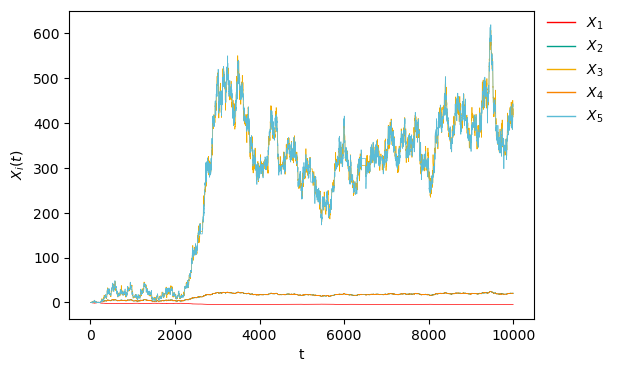

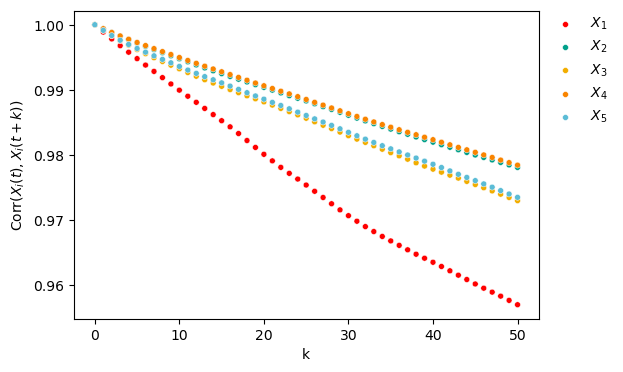

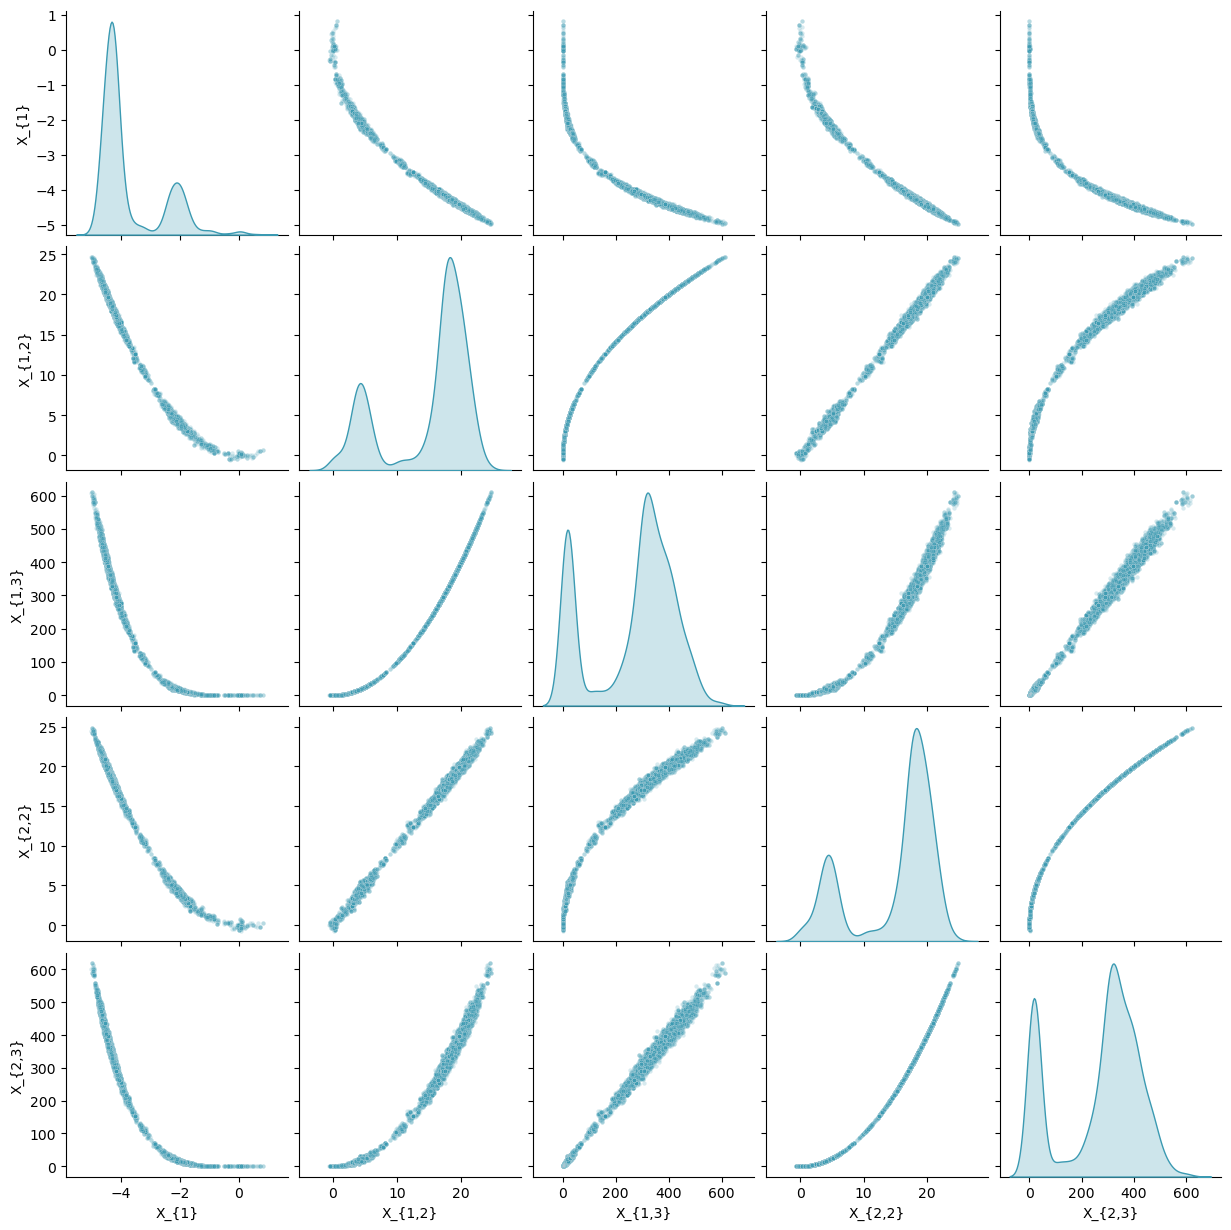

In [81]:
N1 = 3
N2 = 2
X_INIT = [0, 0, 0, 0, 0]
N_ITER = 10000

# X_smmala, accept_rate = SMMALA(
#     logpi=logpi_rosenbrock,
#     partial_logpi=partial_logpi_rosenbrock,
#     hessian_logpi=hessian_logpi_rosenbrock,
#     n_iter=N_ITER,
#     x_init=X_INIT,
#     step_size=0.59,
#     n1=N1,
#     n2=N2
# )
# print(f'SMMALA acceptance rate: {accept_rate}')

X_smbarker, accept_rate = SMBarker(
    logpi=logpi_rosenbrock,
    partial_logpi=partial_logpi_rosenbrock,
    hessian_logpi=hessian_logpi_rosenbrock,
    n_iter=N_ITER,
    x_init=X_INIT,
    step_size=0.9,
    n1=N1,
    n2=N2
)
print(f'SMBarker acceptance rate: {accept_rate}')

# traceplot(X_smmala)
traceplot(X_smbarker)

# acfplot(X_smmala)
acfplot(X_smbarker)

# pairplot(X_smmala, N1, N2)
pairplot(X_smbarker, N1, N2)

In [87]:
N1 = 3
N2 = 1
X_INIT = [0, 0, 0]
N_ITER = 10000

X_smmala, accept_rate = SMMALA(
    logpi=logpi_rosenbrock,
    partial_logpi=partial_logpi_rosenbrock,
    hessian_logpi=hessian_logpi_rosenbrock,
    n_iter=N_ITER,
    x_init=X_INIT,
    step_size=0.59,
    n1=N1,
    n2=N2
)
print(f'SMMALA acceptance rate: {accept_rate}')

traceplot(X_smmala)

acfplot(X_smmala)

pairplot(X_smmala, N1, N2)

LinAlgError: When `allow_singular is False`, the input matrix must be symmetric positive definite.